In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df = pd.read_csv('train.csv')

male, female = df.groupby('Sex')['Age'].mean()

# df['Age'] = df.groupby('Sex')['Age'].apply(lambda x: x.fillna(x.mean()))
df['Age'] = df.groupby('Sex')['Age'].apply(lambda x: x.fillna(x.mean())).reset_index(drop=True)

df['Cabin'].fillna('U', inplace=True)
df['Embarked'].fillna('U', inplace=True)

# print('male median: %.3f, female median: %.3f' % (male, female))
# print('Cabin null values: %.2d'
#       '\nEmbarked null values: %.2d' % (df['Cabin'].isnull().sum(), df['Embarked'].isnull().sum()))

In [4]:
df_mod = df.copy()

df_mod['Sex'].replace({'male':0, 'female':1}, inplace=True)
df_mod['Embarked'].replace({'U':0, 'S':1, "C":2, 'Q':3}, inplace=True)

df_mod.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [5]:
features = df_mod.drop('Survived', axis=1).to_numpy()
target = df_mod['Survived']

x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=.25, random_state=17)

# Урок 4. Метрики качества классификации ч.2

Продолжим работу с метриками классификации. В предыдущем задании мы разобрали матрицу ошибок и две основные метрики, которые используются при бинарной классификации.

Сейчас рассмотрим F-меру - совокупную метрику по precision и recall - и более сложную AUC-ROC.

### 2.1
Из задания к предыдущему уроку выберите классификатор, который давал наименьшее значение recall, вычислите для него precision, применив precision_score, и самостоятельно посчитайте F1-меру (расчеты должны присутствовать). Затем проверьте ответ, используя встроенную функцию.

Сравните полученную f1-меру со значением среднего арифметического полноты и точности.

In [6]:
from sklearn.metrics import precision_score, f1_score

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

dtc = DecisionTreeClassifier(random_state=17)
dtc_model = dtc.fit(x_train, y_train)

precision = precision_score(y_test, dtc_model.predict(x_test))

cm = confusion_matrix(y_test, dtc_model.predict(x_test))
recall = cm[1,1] / (cm[1,1] + cm[1,0])

f1_calculated = 2 * precision * recall / (precision + recall)
f1_true = f1_score(y_test, dtc_model.predict(x_test))

print(f'f1 calculated: {f1_calculated}\nf1 true:       {f1_true}')

f1 calculated: 0.6808510638297872
f1 true:       0.6808510638297872


В библиотеке sklearn есть удобная функция classification_report, возвращающая precision, recall, F-меру и количество экземпляров каждого класса в удобном для чтения формате. Также существует функция precision_recall_fscore_support, возвращающая те же самые метрики, но в форме массива.

### 2.2
Для каждого классификатора из предыдущего урока рассчитайте и выведите следующие импортированные метрики.

In [8]:
df_mod.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,38.0,1,0,7.2500,1
1,1,1,1,26.0,1,0,71.2833,2
2,1,3,1,35.0,0,0,7.9250,1
3,1,1,1,27.0,1,0,53.1000,1
4,0,3,0,14.0,0,0,8.0500,1


In [9]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

In [10]:
prfs = precision_recall_fscore_support(y_test, dtc_model.predict(x_test))
prfs_array = classification_report(y_test, dtc_model.predict(x_test))

print(prfs_array)


              precision    recall  f1-score   support

           0       0.78      0.76      0.77       131
           1       0.67      0.70      0.68        92

    accuracy                           0.73       223
   macro avg       0.72      0.73      0.72       223
weighted avg       0.73      0.73      0.73       223



Вернемся к классификатору LogisticRegression, который мы обучали в предыдущем задании. Там мы не затрагивали настройку гиперпараметров: сделать это можно с помощью LogisticRegressionCV - перебора параметров по сетке с последующей кросс-валидацией (по сути это аналог GridSearchCV, но со своими параметрами внутри, применимыми только к логистической регрессии). Этот класс создан специально для логистической регрессии, т.к. для нее известны эффективные алгоритмы перебора параметров.

У LogisticRegression есть гиперпараметр C - обратный коэффициент регуляризации. Не вдаваясь в подробное описание по формуле, можно сказать, что C соответствует "сложности" модели: чем больше C, тем более сложные зависимости может восстанавливать модель; если параметр C слишком мал (слишком сильная регуляризация), то модель окажется недообученной, а если наоборот регуляризация слишком слабая (т.е. C принимает большие значения), то скорее всего модель окажется переобученной, потому как модель будет слишком "бояться" ошибиться на обучающей выборке.

### 2.3

1. Используя StratifiedKFold, разбейте данные для кросс-валидации по 5-ти блокам (не забывайте во всех методах использовать random_state=17).
2. С помощью numpy.logspace разбейте интервал (-1, 2) на 500 значений.
3. С помощью LogisticRegressionCV подберите оптимальный параметр C: установите гиперпараметр Cs равным объекту из п.2 (разбиение интервала (-1, 2) отвечает за подбор обратного коэффициента регуляризации C); cv равным объекту из п.1 (разбиение для кросс-валидации); scoring равным "roc_auc" (отвечает за оптимизацию гиперпараметров на кросс-валидации: метрика, установленная в scoring, контролирует, как оценивать модель при каждом из наборе параметров, т.е. показывает, какая метрика должна быть наилучшей).
4. Обучите полученную модель на тренировочных данных.

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegressionCV
import numpy as np

In [25]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=17)
skf_split = skf.split(features, target)
log_line = np.logspace(-1, 2, num=500)

lrcv = LogisticRegressionCV(Cs=log_line, cv=skf, scoring='roc_auc', max_iter=150)
lrcv_model = lrcv.fit(x_train, y_train)

In [48]:
np.mean(lrcv_model.scores_[1].T, axis=1)

array([0.83573351, 0.83606569, 0.83606569, 0.83630436, 0.83625731,
       0.83611446, 0.83640017, 0.83640132, 0.83620797, 0.83625617,
       0.83625617, 0.83692283, 0.83654303, 0.8362074 , 0.83687636,
       0.83754246, 0.83749656, 0.83768646, 0.83801979, 0.83768531,
       0.83811274, 0.83801692, 0.83758778, 0.83777998, 0.83730149,
       0.83754246, 0.8377794 , 0.8377794 , 0.83796931, 0.83792111,
       0.83811159, 0.83787349, 0.83777596, 0.83763196, 0.83758434,
       0.83767958, 0.83767958, 0.83772777, 0.83748795, 0.83763024,
       0.83772605, 0.837679  , 0.83763138, 0.83758491, 0.8374891 ,
       0.83753729, 0.83753729, 0.83753672, 0.83734624, 0.83734624,
       0.83729862, 0.83734624, 0.83729748, 0.83734509, 0.83720224,
       0.83729862, 0.8374891 , 0.83768072, 0.83758548, 0.83768015,
       0.83768015, 0.83768015, 0.83782301, 0.83777481, 0.83777481,
       0.83787005, 0.83782243, 0.83777424, 0.83767785, 0.83777367,
       0.83786948, 0.83786948, 0.8378689 , 0.83777367, 0.83782

### 2.4
Используя метод plot из matplotlib.pyplot, выведите график зависимости auc_roc от значения C.

*Примечание: значения по оси x - разбиение с помощью np.logspace из п.2 предыдущего задания, а значения по оси y - среднее значение roc_auc по каждой валидации, т.е. среднее значение из полученных на каждом из 5-ти разбиений при данном параметре C (используйте метод scores_ объекта, который инкапсулирует LogisticRegressionCV).*

In [26]:
import matplotlib.pyplot as plt

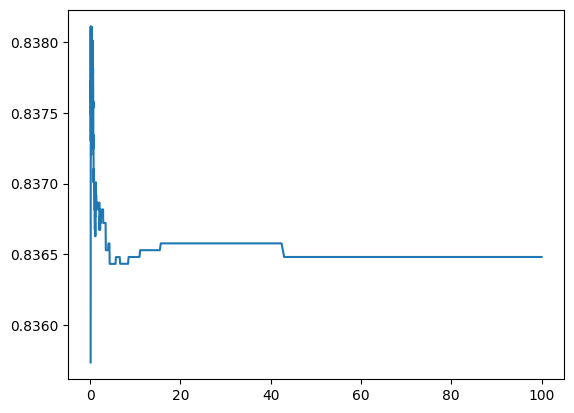

In [47]:
plt.plot(log_line, np.mean(lrcv_model.scores_[1].T, axis=1))




### 2.5
С помощью метода C_ того же объекта выведите лучшее значение C. Выведите более конкретную область графика (область ~15 точкам по x), включающую лучшее значение C.

*Примечание: используйте plt.xlim.*

In [50]:
lrcv_model.C_

array([0.13189869])

(-0.36810131038013294, 15.0)

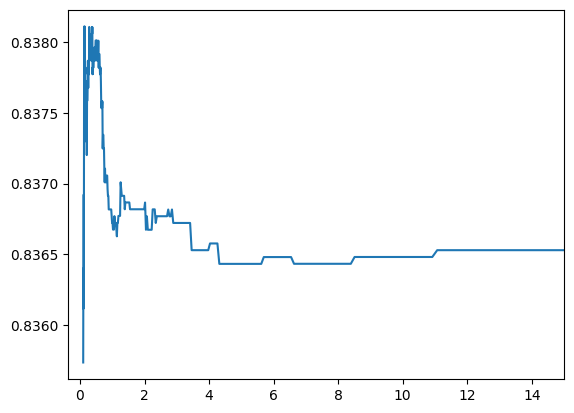

In [56]:
plt.plot(log_line, np.mean(lrcv_model.scores_[1].T, axis=1))
plt.xlim(left=(lrcv_model.C_-0.5), right=15)


### 2.6
С помощью метода predict_proba получите вероятности принадлежности объектов тестовой выборки к классам. Постройте график roc_auc для тестовой выборки и выведите значение auc.

**Пример** построения графика.

In [57]:
from sklearn.metrics import roc_auc_score, roc_curve

In [58]:
probas = logit_search.fit(x_train, y_train).predict_proba(x_train)
fpr, tpr, _ = roc_curve(y_train, probas[:, 1])
auc = roc_auc_score(y_train, probas[:, 1])
plt.plot(fpr, tpr, label="auc=" + str(auc))
plt.legend(loc=4)

NameError: name 'logit_search' is not defined

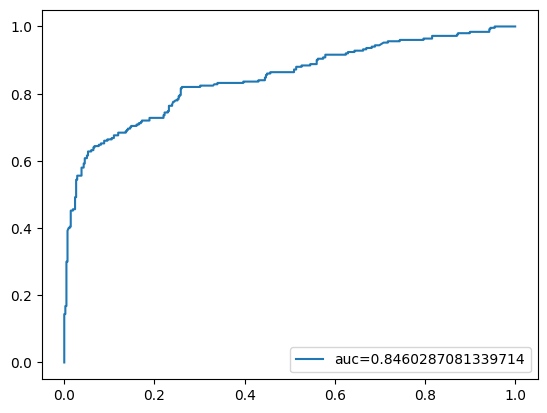

In [59]:
probas = lrcv_model.fit(x_train, y_train).predict_proba(x_train)
fpr, tpr, _ = roc_curve(y_train, probas[:, 1])
auc = roc_auc_score(y_train, probas[:, 1])
plt.plot(fpr, tpr, label="auc=" + str(auc))
plt.legend(loc=4)